I'm running a few sets of chains that are fitting the redMagic HOD to a shuffled SHAM, as well as SHAMs with assembly bias to see what happens. I want all the tests I want to do to be in one place. This notebook will do the following:
* Load the chain and plot the contours
* Calculate the MAP values
* Load the original HOD and clustering for the SHAM sample of interest. 
* Populate the halo catalog and calculate its clustering.
* Plot the best fit clustering against the clustering in the fit
* Plot the best fit HOD to the true HOD of the sample

In [192]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [193]:
import numpy as np
from chainconsumer import ChainConsumer

In [194]:
from astropy.table import Table
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, wp, tpcf
from pearce.mocks import cat_dict
from pearce.mocks.customHODModels import *
from math import ceil

In [195]:
#fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_vpeak_sham_hs.npy'
#fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_shuffled_sham_2.npy'
#fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_vpeak_sham_free_split_3.npy'
fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_vpeak_sham_free_split_fixed_sat.npy'

In [196]:
chain = np.genfromtxt(fname )

In [197]:
n_walkers = 100
n_burn = 200
n_params = chain.shape[1]

In [198]:
c = chain.reshape((n_walkers, -1, n_params))
chain = c[:,n_burn:, :].reshape((-1, n_params))

In [199]:
chain[:10,:]

array([[-0.46292502,  0.87844162,  0.87360206],
       [-0.46292502,  0.87844162,  0.87360206],
       [-0.46292502,  0.87844162,  0.87360206],
       [-0.43534355,  0.83388006,  0.90020514],
       [-0.43534355,  0.83388006,  0.90020514],
       [-0.39757312,  0.8757218 ,  0.91245864],
       [-0.47654122,  0.84632276,  0.97059234],
       [-0.44316456,  0.87420174,  0.9557327 ],
       [-0.44214306,  0.8732153 ,  0.95761952],
       [-0.38134524,  0.81514794,  0.94310005]])

In [200]:
#param_names = [r'$\log{M_{min}}$', r'$\log{M_0}$',r'$\sigma_{log{M}}$', r'$\log{M_1}$', r'$\alpha$']
#param_names = [r'$f_{sat}$',r'$\mathcal{A}_{sat}$',r'$f_{cen}$', r'$\mathcal{A}_{cen}$']
param_names = [r'$\mathcal{A}_{sat}$',r'$f_{cen}$', r'$\mathcal{A}_{cen}$']

#param_names = [r'$\mathcal{A}_{sat}$',r'$\mathcal{A}_{cen}$']

In [201]:
c = ChainConsumer()
c.add_chain(chain, parameters=param_names, walkers=n_walkers, name = 'Free Split')
#c.configure(statistics='cumulative')

In [202]:
#fname2 = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_vpeak_sham_hs.npy'

fname2 = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_vpeak_sham_hs.npy'


In [203]:
chain2 = np.genfromtxt(fname2 )

In [204]:
n_params = chain2.shape[1]

In [205]:
_c = chain2.reshape((n_walkers, -1, n_params))
chain2 = _c[:,n_burn:, :].reshape((-1, n_params))

In [206]:
#param_names = [r'$\log{M_{min}}$', r'$\log{M_0}$',r'$\sigma_{log{M}}$', r'$\log{M_1}$', r'$\alpha$']
#param_names = [r'$f_{sat}$',r'$\mathcal{A}_{sat}$',r'$f_{cen}$', r'$\mathcal{A}_{cen}$']
param_names2 = [r'$\mathcal{A}_{sat}$',r'$\mathcal{A}_{cen}$']

In [207]:
c.add_chain(chain2, parameters=param_names2, walkers=n_walkers, name = 'Heaviside')
#c.configure(statistics='cumulative')

In [208]:
gelman_rubin_converged = c.diagnostic.gelman_rubin()
print gelman_rubin_converged

Gelman-Rubin Statistic values for chain Free Split
$\mathcal{A}_{sat}$: 1.02076 (Passed)
$f_{cen}$: 1.03660 (Passed)
$\mathcal{A}_{cen}$: 1.04014 (Passed)
Gelman-Rubin Statistic values for chain Heaviside
$\mathcal{A}_{sat}$: 1.01651 (Passed)
$\mathcal{A}_{cen}$: 1.02816 (Passed)
True


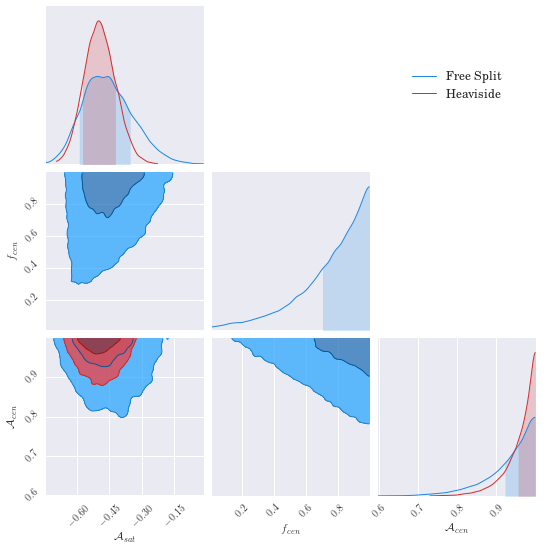

In [209]:
fig = c.plotter.plot(figsize=(8,8), parameters=param_names)
fig.show()

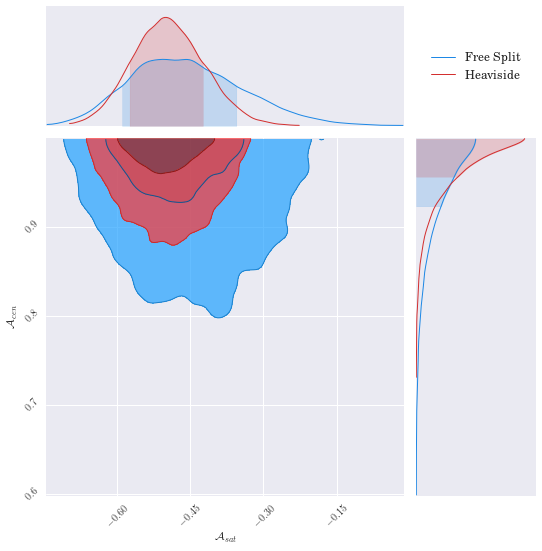

In [210]:
fig = c.plotter.plot(figsize=(8,8), parameters=param_names2)
fig.show()

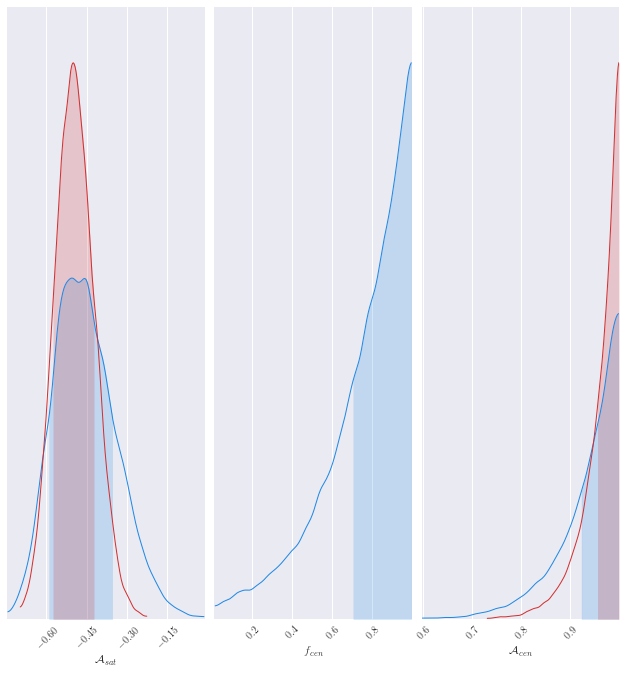

In [211]:
fig = c.plotter.plot_distributions(figsize=(10,10) )
fig.show()

In [212]:
summary  = c.analysis.get_summary()
MAP = np.array([summary[0][p][1] for p in param_names])
print MAP

[-0.50611615  0.99616451  0.99834493]


In [213]:
#MAP[0] = 0.65
#MAP[1] = -0.75

MAP[0] = 0.9
MAP[1] = -1.0

In [214]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048

halo_catalog = Table.read('/u/ki/swmclau2/des/AB_tests/abmatched_halos.hdf5', format = 'hdf5')

In [215]:
shuffle_type = ''
mag_type = 'vpeak'
mag_key = 'halo_%s_mag'%(mag_type)
upid_key = 'halo_upid'

#mag_key = 'halo%s_%s_mag'%(shuffle_type, mag_type)
#upid_key = 'halo%s_upid'%shuffle_type

In [216]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
#cat.h = 1.0

In [217]:
mag_cut = -21
min_ptcl = 200

halo_catalog = halo_catalog[halo_catalog['halo_mvir'] > min_ptcl*cat.pmass] #mass cut
galaxy_catalog = halo_catalog[ halo_catalog[mag_key] < mag_cut ] # mag cut

In [218]:
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.1):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [219]:
mass_bins = compute_mass_bins(halo_catalog['halo_mvir'], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
#mass_bin_centers = 10**((np.log10(mass_bins[1:])+np.log10(mass_bins[:-1]))/2.0)

In [220]:
cen_mask = galaxy_catalog['halo_upid']==-1
mass_key = 'halo_mvir_host_halo'#
#mass_key = 'halo_%s_host_mvir'%shuffle_type
cen_hod_sham, _ = hod_from_mock(galaxy_catalog[cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_sham, _ = hod_from_mock(galaxy_catalog[~cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [221]:
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/cen_hod.npy', cen_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sat_hod.npy', sat_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/mbc.npy', mass_bin_centers)

In [222]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_free_split_no_rsd/'

In [223]:
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy')
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rp_bins = np.loadtxt(training_dir+'a_1.00000/global_file.npy')

#rp_bins = np.logspace(-1.1, 1.6, 16)
#rpoints =  np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rpoints = (rp_bins[1:]+rp_bins[:-1])/2.0

#wp_sham = np.log10(np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s%s_wp.npy'%(mag_type, shuffle_type)))

In [224]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy', rp_bins)

In [225]:
#cat.load_model(1.0, HOD='redMagic')
cat.load_model(1.0, HOD=(FSAssembiasTabulatedCens, FSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
#cat.load_model(1.0, HOD=(HSAssembiasTabulatedCens, HSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
                                                               'cen_hod_vals':cen_hod_sham,
                                                               'sat_hod_vals':sat_hod_sham})

In [226]:
cat.model.param_dict

{'mean_occupation_centrals_assembias_param1': 0.5,
 'mean_occupation_centrals_assembias_split1': 0.5,
 'mean_occupation_satellites_assembias_param1': 0.5,
 'mean_occupation_satellites_assembias_split1': 0.5}

In [227]:
#summary  = c.analysis.get_summary()
#MAP = np.array([summary[p][1] for p in param_names])
#MAP = np.zeros((len(param_names),))
#MAP = chain[np.random.randint(chain.shape[0]), :]
print MAP

[ 0.9        -1.          0.99834493]


In [263]:
param_names

['$\\mathcal{A}_{sat}$', '$f_{cen}$', '$\\mathcal{A}_{cen}$']

In [264]:
names = ['mean_occupation_satellites_assembias_param1',
          'mean_occupation_centrals_assembias_split1', 'mean_occupation_centrals_assembias_param1']
#names = ['logMmin','logM0','sigma_logM', 'logM1', 'alpha']
#names = ['mean_occupation_satellites_assembias_param1', 'mean_occupation_centrals_assembias_param1']

In [265]:
params = dict(zip(names, MAP))
#params['f_c'] = 1.0
cat.populated_once = False
cat.populate(params)

In [266]:
cat.model.param_dict

{'mean_occupation_centrals_assembias_param1': 0.98221550177106287,
 'mean_occupation_centrals_assembias_split1': 0.97091633972612135,
 'mean_occupation_satellites_assembias_param1': -0.29587016339172911,
 'mean_occupation_satellites_assembias_split1': 0.90000000000000002}

In [267]:
cen_mask = cat.model.mock.galaxy_table['gal_type']=='centrals'
cen_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[~cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [268]:
wp_hod = cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False, RSD=False)
print wp_hod
#wp_hod = cat.calc_xi(rp_bins, do_jackknife=False)

[ 789.46774373  542.67538517  358.02791422  255.5999802   178.3772804
  125.0692502    94.31092816   66.80655172   51.07785118   39.45859111
   30.08182425   22.48089523   16.26588801   11.28226312    7.5820654
    4.53494209    2.25671599    0.86580976]


In [269]:
from halotools.mock_observables import return_xyz_formatted_array

In [270]:
#sham_pos = np.c_[galaxy_catalog['halo_%s_x'%shuffle_type],\
#                 galaxy_catalog['halo_%s_y'%shuffle_type],\
#                 galaxy_catalog['halo_%s_z'%shuffle_type]]

sham_pos = np.c_[galaxy_catalog['halo_x'],\
                 galaxy_catalog['halo_y'],\
                 galaxy_catalog['halo_z']]
distortion_dim = 'z'
v_distortion_dim = galaxy_catalog['halo_v%s' % distortion_dim]
# apply redshift space distortions
#sham_pos = return_xyz_formatted_array(sham_pos[:,0],sham_pos[:,1],sham_pos[:,2],  velocity=v_distortion_dim, \
 #                                velocity_distortion_dimension=distortion_dim, period=cat.Lbox)
wp_sham = wp(sham_pos*cat.h, rp_bins, 40.0*cat.h, period=cat.Lbox*cat.h, num_threads=1)
print wp_sham
#wp_sham = tpcf(sham_pos*h, rp_bins, period=400.0*h, num_threads=1)

#wp_sham = np.log10(wp(sham_pos, rp_bins, 40.0, period=400.0, num_threads=1))

[ 584.13088582  446.77230202  352.39713097  233.66110444  170.22857317
  116.8310956    86.1341947    63.34798862   47.95916411   36.86749563
   28.27748673   20.94600314   15.09222186   10.6114766     6.99502884
    4.19488178    2.07652477    0.73773839]


In [271]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s_%s_wp.npy'%(mag_type, shuffle_type), wp_sham)
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_vpeak_shuffled_nd.npy',np.array([cat.calc_analytic_nd()]) )

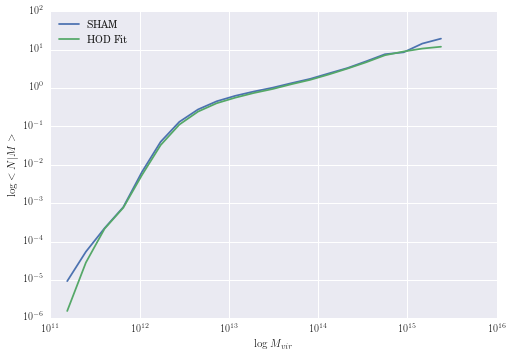

In [272]:
plt.plot(mass_bin_centers, cen_hod_sham+sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock+sat_hod_mock, label = 'HOD Fit')
plt.legend(loc='best')
plt.xlabel(r"$\log{M_{vir}}$")
plt.ylabel(r"$\log{<N|M>}$")
plt.loglog()
plt.show();

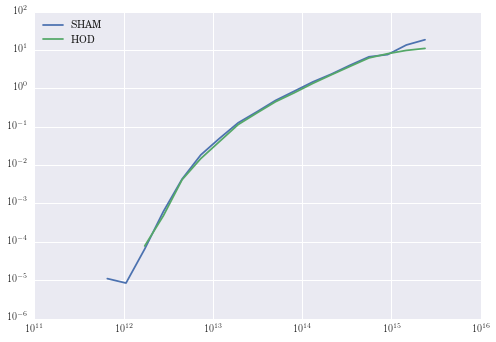

In [273]:
plt.plot(mass_bin_centers, sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, sat_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

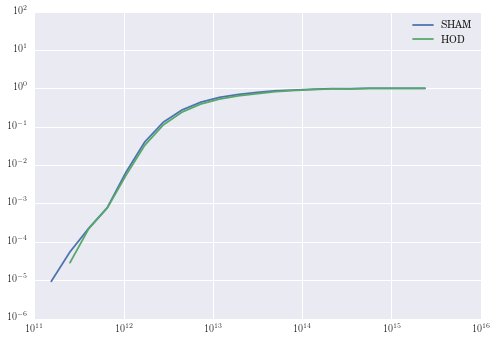

In [274]:
plt.plot(mass_bin_centers, cen_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

In [275]:
sham_nd = len(galaxy_catalog)/(cat.Lbox*0.7)**3
hod_nd = cat.calc_analytic_nd()

In [276]:
print sham_nd/hod_nd

1.11534160321


In [277]:
fs_cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

fs_cat.load_catalog(1.0)
fs_cat.load_model(1.0, HOD=(FSAssembiasTabulatedCens, FSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
                                                               'cen_hod_vals':cen_hod_sham,
                                                               'sat_hod_vals':sat_hod_sham})

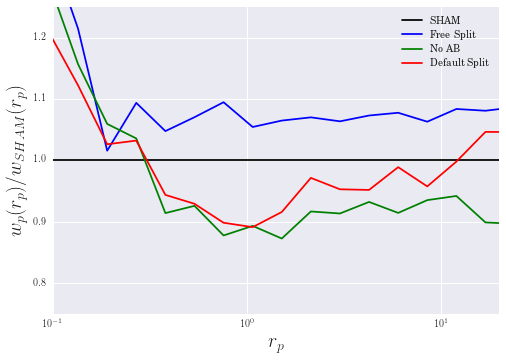

In [293]:
plt.plot(rpoints, wp_sham/wp_sham, label = 'SHAM', color = 'k')
plt.plot(rpoints, wp_hod/wp_sham, label = 'Free Split', color = 'b')
names = ['mean_occupation_satellites_assembias_param1',
         'mean_occupation_centrals_assembias_param1',
          #'mean_occupation_satellites_assembias_split1',
          'mean_occupation_centrals_assembias_split1']
MAP = np.array([0.0, 0.0,0.5, 0.5])
params = dict(zip(names, MAP))
fs_cat.populate(params)
wp_hod_noab = fs_cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False )
#wp_hod_noab = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

plt.plot(rpoints, wp_hod_noab/wp_sham, label = 'No AB', color = 'g')

MAP = np.array([-0.5, 1.0,0.5, 0.5])
params = dict(zip(names, MAP))
fs_cat.populate(params)
wp_hod_norm_split = fs_cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False )
#wp_hod_noab = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

plt.plot(rpoints, wp_hod_norm_split/wp_sham, label = 'Default Split', color = 'r')

#plt.loglog()
plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$r_p$", fontsize = 20)
plt.ylabel(r"$w_p(r_p)/w_{SHAM}(r_p)$", fontsize = 20)
plt.xlim([0.1, 20])
plt.ylim([0.75, 1.25])
plt.show()

In [294]:
wp_sham

array([ 584.13088582,  446.77230202,  352.39713097,  233.66110444,
        170.22857317,  116.8310956 ,   86.1341947 ,   63.34798862,
         47.95916411,   36.86749563,   28.27748673,   20.94600314,
         15.09222186,   10.6114766 ,    6.99502884,    4.19488178,
          2.07652477,    0.73773839])

In [295]:
c.comparison.bic()

[None, None]

In [296]:
wp_hod

array([ 789.46774373,  542.67538517,  358.02791422,  255.5999802 ,
        178.3772804 ,  125.0692502 ,   94.31092816,   66.80655172,
         51.07785118,   39.45859111,   30.08182425,   22.48089523,
         16.26588801,   11.28226312,    7.5820654 ,    4.53494209,
          2.25671599,    0.86580976])

In [297]:
np.log10(wp_hod_noab)

array([ 2.87721132,  2.71337116,  2.57218234,  2.38392676,  2.19213472,
        2.03421758,  1.87860139,  1.75281829,  1.62182105,  1.52899422,
        1.4122356 ,  1.29074638,  1.13999407,  0.99678648,  0.81893657,
        0.57653084,  0.27003322, -0.22048614])

In [298]:
new_params = {'mean_occupation_centrals_assembias_param1': 0.84999999999999998,
 'mean_occupation_centrals_assembias_split1': 0.84999999999999998,
 'mean_occupation_satellites_assembias_param1': -0.29999999999999999,
 'mean_occupation_satellites_assembias_split1': 0.90000000000000002}

In [299]:
fs_cat.populate(new_params)
print np.log10(fs_cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False ))

[ 2.85376024  2.70873118  2.53961297  2.40514339  2.23170011  2.07192638
  1.93358768  1.79689585  1.68456961  1.57372488  1.45271032  1.32532413
  1.19222252  1.03670367  0.84476286  0.62935635  0.36358496 -0.09144458]


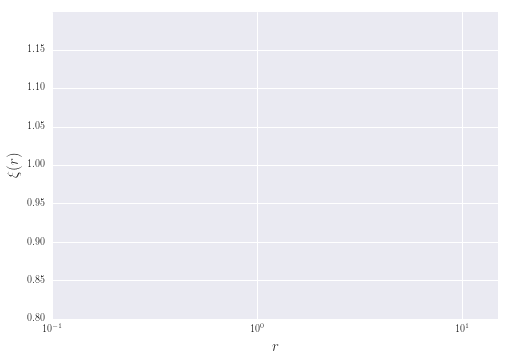

In [300]:
plt.figure
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 15e0]);
plt.ylim([0.8,1.2])
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)$',fontsize = 15)
plt.show()

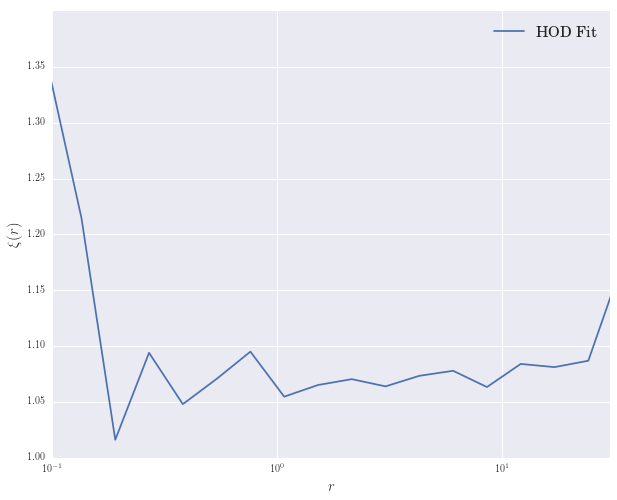

In [301]:
plt.figure(figsize=(10,8))

#plt.plot(rpoints, wp_sham/wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_hod/wp_sham, label = 'HOD Fit')
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 30e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)$',fontsize = 15)
plt.show()

In [302]:
print wp_sham/wp_hod

[ 0.73990469  0.82327726  0.98427278  0.91416715  0.95431757  0.93413125
  0.91330025  0.94823018  0.93894248  0.93433381  0.94001901  0.9317246
  0.92784494  0.94054504  0.92257564  0.92501331  0.92015335  0.85207909]


In [303]:
print wp_sham
print wp_hod

[ 584.13088582  446.77230202  352.39713097  233.66110444  170.22857317
  116.8310956    86.1341947    63.34798862   47.95916411   36.86749563
   28.27748673   20.94600314   15.09222186   10.6114766     6.99502884
    4.19488178    2.07652477    0.73773839]
[ 789.46774373  542.67538517  358.02791422  255.5999802   178.3772804
  125.0692502    94.31092816   66.80655172   51.07785118   39.45859111
   30.08182425   22.48089523   16.26588801   11.28226312    7.5820654
    4.53494209    2.25671599    0.86580976]


In [304]:
from pearce.emulator import OriginalRecipe, ExtraCrispy

In [305]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_free_split_no_rsd/'
#training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_tabulated_no_split/'

em_method = 'gp'
split_method = 'random'

load_fixed_params = {'z':0.0}

emu = ExtraCrispy(training_dir,10, 2, split_method, method=em_method, fixed_params=load_fixed_params)

In [306]:
names

['mean_occupation_satellites_assembias_param1',
 'mean_occupation_centrals_assembias_param1',
 'mean_occupation_centrals_assembias_split1']

{'mean_occupation_satellites_assembias_split1': 0.5, 'mean_occupation_satellites_assembias_param1': -0.48625370674228663, 'mean_occupation_centrals_assembias_split1': 0.9232682127567674, 'mean_occupation_centrals_assembias_param1': 0.34339023937357716}
{'mean_occupation_satellites_assembias_split1': 0.5, 'mean_occupation_satellites_assembias_param1': -0.50696368280425275, 'mean_occupation_centrals_assembias_split1': 0.88673907253363426, 'mean_occupation_centrals_assembias_param1': 0.65235901767130766}
{'mean_occupation_satellites_assembias_split1': 0.5, 'mean_occupation_satellites_assembias_param1': -0.48512001540163979, 'mean_occupation_centrals_assembias_split1': 0.8412637720806776, 'mean_occupation_centrals_assembias_param1': 0.89977381727413364}
{'mean_occupation_satellites_assembias_split1': 0.5, 'mean_occupation_satellites_assembias_param1': -0.2894202370886434, 'mean_occupation_centrals_assembias_split1': 0.97235376928288186, 'mean_occupation_centrals_assembias_param1': 0.710919

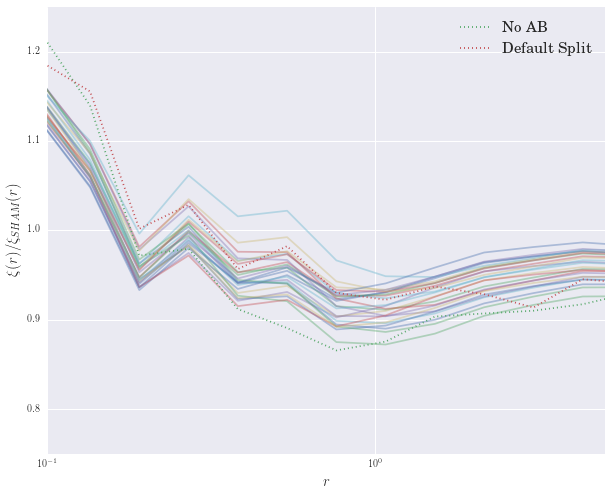

In [307]:
plt.figure(figsize=(10,8))
for i in xrange(25):
    MAP = chain[np.random.randint(chain.shape[0]), :]
    params = dict(zip(names, MAP))
    params.update({'mean_occupation_satellites_assembias_split1':0.5})
    print params
    #params['f_c'] = 1.0
    #cat.populated_once = False
    #cat.populate(params)
    #wp_hod = cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1, RSD = False)
    wp_emu = 10**emu.emulate_wrt_r(params, rpoints)[0]
    #wp_hod = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

    plt.plot(rpoints, wp_emu/wp_sham, alpha = 0.4)

#plt.plot(rpoints, wp_sham, label = 'SHAM')
names = ['mean_occupation_satellites_assembias_param1',
         'mean_occupation_centrals_assembias_param1',
          'mean_occupation_satellites_assembias_split1',
          'mean_occupation_centrals_assembias_split1']
MAP = np.array([0.0, 0.0,0.5, 0.5])
params = dict(zip(names, MAP))
print params
fs_cat.populate(params)
wp_hod_noab = fs_cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False )
#wp_hod_noab = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

plt.plot(rpoints, wp_hod_noab/wp_sham, ls = ':', label = 'No AB')

MAP = np.array([-0.5, 1.0,0.5, 0.5])
params = dict(zip(names, MAP))
fs_cat.populate(params)
wp_hod_norm_split = fs_cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False )
#wp_hod_noab = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

plt.plot(rpoints, wp_hod_norm_split/wp_sham, ls = ':', label = 'Default Split')

#plt.loglog()
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 5e0]);
plt.ylim([0.75,1.25]);
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)/\xi_{SHAM}(r)$',fontsize = 15)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for i in xrange(25):
    MAP = chain[np.random.randint(chain.shape[0]), :]
    params = dict(zip(names, MAP))
    #params['f_c'] = 1.0
    #cat.populated_once = False
    #cat.populate(params)
    #wp_hod = cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1, RSD = False)
    wp_emu = 10**emu.emulate_wrt_r(params, rpoints)[0]
    #wp_hod = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

    plt.plot(rpoints, wp_emu, alpha = 0.4)

#plt.plot(rpoints, wp_sham, label = 'SHAM')
names = ['mean_occupation_satellites_assembias_param1',
         'mean_occupation_centrals_assembias_param1',
          'mean_occupation_satellites_assembias_split1',
          'mean_occupation_centrals_assembias_split1']
MAP = np.array([0.0, 0.0,0.5, 0.5])
params = dict(zip(names, MAP))
print params
fs_cat.populate(params)
wp_hod_noab = fs_cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False )
#wp_hod_noab = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

plt.plot(rpoints, wp_hod_noab, ls = ':', label = 'No AB')

MAP = np.array([-0.5, 1.0,0.5, 0.5])
params = dict(zip(names, MAP))
fs_cat.populate(params)
wp_hod_norm_split = fs_cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False,n_cores =1 ,RSD = False )
#wp_hod_noab = cat.calc_xi(rp_bins, do_jackknife=False,n_cores =1 )

plt.plot(rpoints, wp_hod_norm_split, ls = ':', label = 'Default Split')

plt.plot(rpoints, wp_sham, lw = 3, label = 'SHAM')

plt.loglog()
#plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 5e0]);
#plt.ylim([0.75,1.25]);
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)/\xi_{SHAM}(r)$',fontsize = 15)
plt.show()

In [ ]:
print wp_hod_noab

In [ ]:
names

In [ ]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ -1.0, 1.0,0.5,0.5])

params = dict(zip(names, MAP))
#print params.keys()

mock_wps = []
#mock_wps_1h, mock_wps_2h = [],[]
#mock_nds = []
split = np.linspace(0.1, 0.9, 4)
#split_abcissa = [10**9, 10**13, 10**16]

for p in split:
    params['mean_occupation_centrals_assembias_split1'] = p
    params['mean_occupation_satellites_assembias_split1'] = p

    fs_cat.populate(params)

    mock_pos = np.c_[fs_cat.model.mock.galaxy_table['x'],\
                     fs_cat.model.mock.galaxy_table['y'],\
                     fs_cat.model.mock.galaxy_table['z']]
    mock_wps.append(wp(mock_pos*cat.h, rp_bins ,40.0*cat.h,  period=cat.Lbox*cat.h, num_threads=1))

    
mock_wps = np.array(mock_wps)

In [ ]:
plt.figure(figsize=(10,8))
#avg = mock_wps.mean(axis = 0)
for p, mock_wp in zip(split, mock_wps):
    plt.plot(rpoints, mock_wp/wp_sham, label = 'p = %.2f'%p)
    #pass
    
plt.plot(rpoints, noab_wp/wp_sham, label = 'No AB', ls = ':')

#plt.loglog()
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 5e0]);
plt.ylim([0.75,1.25]);
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)/\xi_{SHAM}(r)$',fontsize = 15)
plt.show()